## Коломейцев Юрий БД

# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_03.ipynb.

## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат во множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение данной модели сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска. 

В данном случае градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага.

В общем случае метод градиентного спуска имеет некоторые недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификаций.

In [36]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

import math

In [381]:
import scipy.linalg as sla

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

In [93]:
from sklearn.datasets import make_classification

In [94]:
x_data, y_data_zeros = make_classification(n_samples=1000, n_features=20)

In [95]:
y_data = y_data_zeros*2 - 1
y_data[:10]

array([-1,  1,  1, -1,  1,  1, -1, -1,  1,  1])

In [96]:
y_data.shape

(1000,)

In [123]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split( \
                                    x_data, y_data, test_size=0.8, random_state=1537)

**(2.5 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше чем 1e-6
 - ограничить число итераций (например, 10000)
 
Для начальной инициализации весов можно сравнить следующие подходы:
 - нулева начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученный результат:
- Рассмотрите как влияет размер шага на сходимость.
- Сравните влияет ли наличие регуляризации на скорость сходимости и качество.
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

In [300]:
# функция, которая вычисляет функционал (C - коэффициент регуляризации)
def compute_functional(x, y, w, C=0.0):
    prod_xy = np.array(y).reshape((y.size, 1)) * x
    reg = 0.5 * C * np.linalg.norm(w)**2
    return np.sum(np.log(1 + np.exp(-prod_xy.dot(w))), axis=0) / y.size + reg

# функция, которая вычисляет градиент функционала
def compute_gradient(x, y, w, C=0.0):
    prod_xy = np.array(y).reshape((y.size, 1)) * x
    reg = C * w
    return np.sum(-prod_xy/(1 + np.exp(prod_xy.dot(w))), axis=0).reshape(w.shape)/y.size+reg

def predict(x, w):
    prediction = 1 / (1 + np.exp(-x.dot(w)))
    return np.hstack((1 - prediction, prediction))

# возвращает вектор коэффициентов w и список значений функционала на каждой итерации
def gradient_descent(x, y, step, n_iters=10000, rand_init=False, C=0.0):
    if rand_init:
        w = (np.random.rand(x.shape[1]).reshape((x.shape[1], 1)) - 0.5) / x.shape[0]
    else:
        w = np.zeros((x.shape[1], 1))
    losses = []
    for i in range(n_iters):
        loss = compute_functional(x, y, w, C)
        gradient = compute_gradient(x, y, w, C)
        losses.append(loss)
        dif = step * gradient
        w -= step * gradient
        if np.linalg.norm(dif) < 10e-6:
            break
    return w, losses

Рассмотрим как влияет размер шага на сходимость и построим график качества оптимизируемого функционала в зависимости от номера итерации:

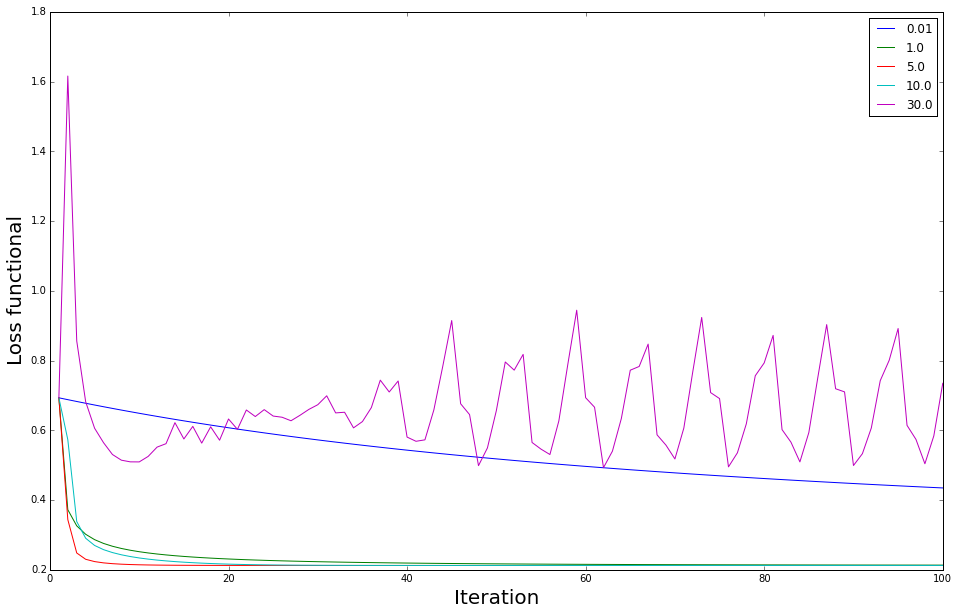

In [236]:
steps = [0.01, 1.0, 5.0, 10.0, 30.0]

plt.figure(figsize=(16, 10))
for step in steps:
    w, losses = gradient_descent(X_train, y_train, step, 100)
    plt.plot(range(1, len(losses) + 1), losses, label = str(step))
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что чем меньше размер шага, тем медленнее сходимость, но если шаг сделать слишком большим, то сходимости вообще не будет (фиолетовый график).

В данном случае быстрее всех сошелся график с шагом, равным $5.0$.

Посмотрим какое при будет качество на тестовой выборке при разных размерах шага (без регуляризации и с нулевой начальной инициальзацией вектора весов). Для измерения качества использую AUC-ROC.

In [201]:
from sklearn.metrics import roc_auc_score

In [223]:
for step in [0.01, 1.0, 10.0]:
    w, losses = gradient_descent(X_train, y_train, step)
    predicted = predict(X_test, w)[:, 1]
    print 'step = ', step, ' ROC-AUC: ', roc_auc_score(y_test, predicted)

step =  0.01  ROC-AUC:  0.920530712285
step =  1.0  ROC-AUC:  0.917992196879
step =  10.0  ROC-AUC:  0.916322779112


Видим, что, чем меньше шаг, тем лучше качество.

При фиксированном шаге, равным $5.0$, посмотрим влияет ли наличие регуляризации на скорость сходимости и качество.

Сначала проанализируем качество:

In [229]:
step = 5.0
reg_koefs = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.2]
for koef in reg_koefs:
    w, losses = gradient_descent(X_train, y_train, step, C=koef)
    predicted = predict(X_test, w)[:, 1]
    print 'step = ', step, 'regularization = ', koef, ' ROC-AUC: ', \
            roc_auc_score(y_test, predicted)

step =  5.0 regularization =  0.0  ROC-AUC:  0.917992196879
step =  5.0 regularization =  0.0001  ROC-AUC:  0.918117246899
step =  5.0 regularization =  0.001  ROC-AUC:  0.9187487495
step =  5.0 regularization =  0.01  ROC-AUC:  0.923857042817
step =  5.0 regularization =  0.1  ROC-AUC:  0.888630452181
step =  5.0 regularization =  0.2  ROC-AUC:  0.477700455182


Видим, что регуляризация влияет на качество. И путем небольшого увеличения коэффициента регуляризации можно повысить качество (если взять большой коэффициент качество упадет). В данном случае качество повысилось с $0.91799$ до $0.923857$.

Теперь посмотрим на скорость сходимости:

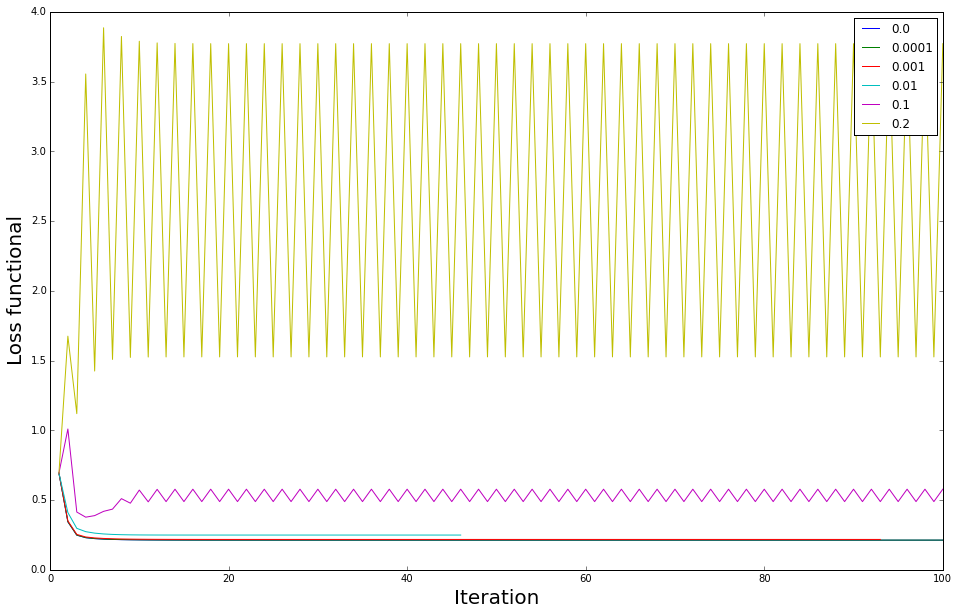

In [230]:
step = 5.0
reg_koefs = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.2]
plt.figure(figsize=(16, 10))
for koef in reg_koefs:
    w, losses = gradient_descent(X_train, y_train, step, C=koef)
    plt.plot(range(1, len(losses) + 1)[:100], losses[:100], label = str(koef))
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что регуляризация влияет и на скорость сходимости. Чем больше коэффициент регуляризации, тем быстрее сходимость. При $C = 0.001$ метод сошелся на примерно на 93 итерации, а при $C = 0.01$ уже примерно на 45 итерации. Но если его взять большим, то сходимости не будет вообще.

Теперь проанализируем, как влияет начальная инициализация весов на скорость и на качество. В качестве случайной инициализации беру равномерное распределение на $(-\frac{1}{2n}, \frac{1}{2n})$

converge zero init:  121
converge random init:  122
converge random init:  121
converge random init:  121
converge random init:  122
converge random init:  121
converge random init:  122
converge random init:  121
converge random init:  121
converge random init:  121
converge random init:  122
converge random init:  122


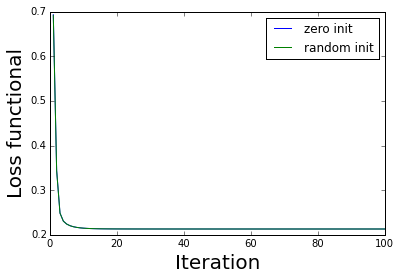

In [318]:
plt.figure(figsize=(6, 4))
w, losses = gradient_descent(X_train, y_train, step=5.0, rand_init=False, C=0.0001)
plt.plot(range(1, len(losses) + 1)[:100], losses[:100], label = 'zero init')
print 'converge zero init: ', len(losses)
w, losses = gradient_descent(X_train, y_train, step=5.0, rand_init=True, C=0.0001)
plt.plot(range(1, len(losses) + 1)[:100], losses[:100], label = 'random init')
print 'converge random init: ', len(losses)
for i in range(10):
    w, losses = gradient_descent(X_train, y_train, step=5.0, rand_init=True, C=0.0001)
    print 'converge random init: ', len(losses)
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что случайная инициализация почти практически не повлияла на скорость сходимости.

Но если увеличить интервал и взять равномерное распределение например $(-\frac{5}{2n}, \frac{5}{2n})$, то в целом скорость сходимости уменьшится (в очень редких случаях немного увеличится).

In [317]:
w, losses = gradient_descent(X_train, y_train, step=5.0, rand_init=False, C=0.0001)
predicted = predict(X_test, w)[:, 1]
print 'zero init ROC-AUC: ', roc_auc_score(y_test, predicted)
for i in range(5):
    w, losses = gradient_descent(X_train, y_train, step=5.0, rand_init=True, C=0.0001)
    predicted = predict(X_test, w)[:, 1]
    print 'random init ROC-AUC: ', roc_auc_score(y_test, predicted)

zero init ROC-AUC:  0.918117246899
random init ROC-AUC:  0.918117246899
random init ROC-AUC:  0.918117246899
random init ROC-AUC:  0.918117246899
random init ROC-AUC:  0.918117246899
random init ROC-AUC:  0.918117246899


Случайная инициализация не повлияла на качество.

В общем, выбор начальной инициализации влияет на скорость, но по моим наблюдениям случаная инициализация (из небольшого интервала около нуля) только ухудшает ее.

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1 балл)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

- Посмотрите как влияет размер шага на сходимость
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации 

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

In [308]:
def stochastic_gradient(x, y, w, i):
    prod_xy = y[i, None] * x[i, :]
    return (-prod_xy / (1 + np.exp(prod_xy.dot(w)))).reshape(w.shape)

def sgd(x, y, step, n_iters=10000, rand_init=False, C=0.0):
    if rand_init:
        w = (np.random.rand(x.shape[1]).reshape((x.shape[1], 1)) - 0.5) / x.shape[0]
    else:
        w = np.zeros((x.shape[1], 1))
    losses = []
    for i in range(n_iters):
        losses.append(compute_functional(x, y, w, C))
        index = np.random.randint(0, y.size - 1)
        gradient = stochastic_gradient(x, y, w, index)
        w_new = w * (1 - step * C) - step * gradient
        if np.linalg.norm(w_new - w) < 10e-6:
            break
        w = w_new
    return w, losses

step =  0.001 converged: iter =  8442
step =  0.01 converged: iter =  2180
step =  0.1 converged: iter =  625
step =  0.2 converged: iter =  208
step =  0.5 converged: iter =  42


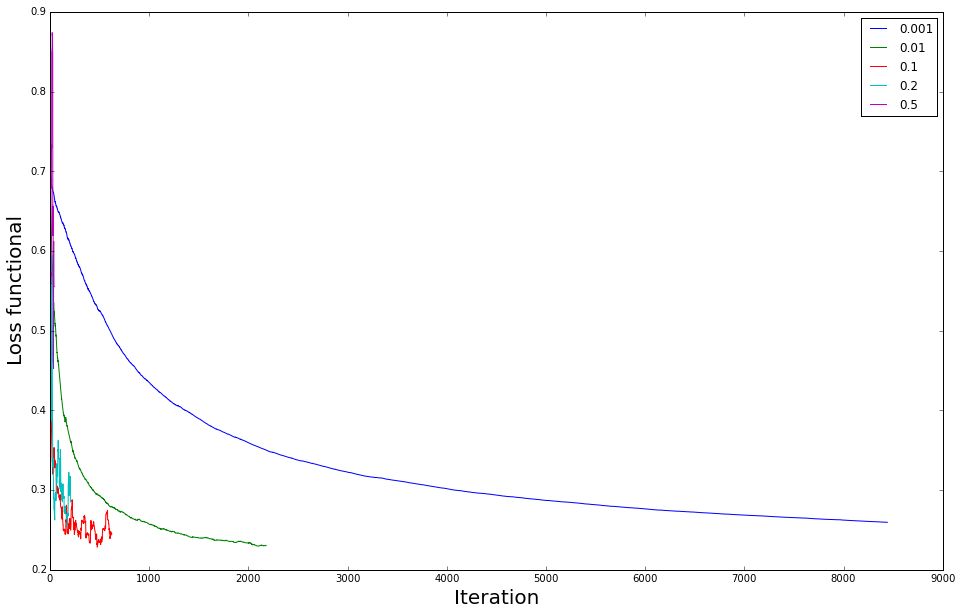

In [333]:
steps = [0.001, 0.01, 0.1, 0.2, 0.5]

plt.figure(figsize=(16, 10))
for step in steps:
    w, losses = sgd(X_train, y_train, step)
    plt.plot(range(1, len(losses) + 1), losses, label = str(step))
    print 'step = ', step, 'converged: iter = ', len(losses)
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что при больших размерах шага, сходимости нет (причем в случае нестохастического градиентного спуска при таких размерах метод бы сошелся). При малых ращмерах шага - чем меньше шаг, тем медленнее и качественней сходимость.

Зафиксируем размер шага и коэффициент регуляризации, а также используем нулевую инициализацию вектора весов и сравним 2 метода (градиентный спуск и sgd):

In [349]:
def compare_methods(step):
    reg_koefs = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]
    quality = []
    print 'step = ', step, '\n'
    print 'gradient_descent:'
    for koef in reg_koefs:
        w, losses = gradient_descent(X_train, y_train, step, C=koef)
        predicted = predict(X_test, w)[:, 1]
        qual = roc_auc_score(y_test, predicted)
        quality.append(qual)
        print 'converge iter = ', len(losses), 'regularization = ', \
                koef, ' ROC-AUC: ', qual
    print 'max quality = ', max(quality)
    quality = []
    print '\nsgd:'
    for koef in reg_koefs:
        w, losses = sgd(X_train, y_train, step, C=koef)
        predicted = predict(X_test, w)[:, 1]
        qual = roc_auc_score(y_test, predicted)
        quality.append(qual)
        print 'converge iter = ', len(losses), 'regularization = ', \
                koef, ' ROC-AUC: ', qual
    print 'max quality = ', max(quality)

In [350]:
compare_methods(0.01)

step =  0.01 

gradient_descent:
converge iter =  10000 regularization =  0.0  ROC-AUC:  0.920530712285
converge iter =  10000 regularization =  0.0001  ROC-AUC:  0.920568227291
converge iter =  10000 regularization =  0.001  ROC-AUC:  0.920899609844
converge iter =  9294 regularization =  0.01  ROC-AUC:  0.924219687875
converge iter =  2308 regularization =  0.1  ROC-AUC:  0.932616796719
converge iter =  1403 regularization =  0.2  ROC-AUC:  0.933673469388
converge iter =  708 regularization =  0.5  ROC-AUC:  0.933410864346
max quality =  0.933673469388

sgd:
converge iter =  1897 regularization =  0.0  ROC-AUC:  0.929928221289
converge iter =  1933 regularization =  0.0001  ROC-AUC:  0.929971988796
converge iter =  10000 regularization =  0.001  ROC-AUC:  0.921831232493
converge iter =  10000 regularization =  0.01  ROC-AUC:  0.92174994998
converge iter =  10000 regularization =  0.1  ROC-AUC:  0.928465136054
converge iter =  10000 regularization =  0.2  ROC-AUC:  0.930465936375
conv

При шаге $0.01$ в случае увеличения регуляризации градиентный спуск сходится быстрее, а sgd наоборот - медленнее, да и в целом sgd сходится в данном случае медленнее, чем sgd.

Увеличим шаг:

In [360]:
compare_methods(0.1)

step =  0.1 

gradient_descent:
converge iter =  4049 regularization =  0.0  ROC-AUC:  0.918042216887
converge iter =  3962 regularization =  0.0001  ROC-AUC:  0.918117246899
converge iter =  3350 regularization =  0.001  ROC-AUC:  0.918805022009
converge iter =  1534 regularization =  0.01  ROC-AUC:  0.923913315326
converge iter =  356 regularization =  0.1  ROC-AUC:  0.932516756703
converge iter =  211 regularization =  0.2  ROC-AUC:  0.933573429372
converge iter =  102 regularization =  0.5  ROC-AUC:  0.933398359344
max quality =  0.933573429372

sgd:
converge iter =  486 regularization =  0.0  ROC-AUC:  0.925201330532
converge iter =  10000 regularization =  0.0001  ROC-AUC:  0.921099689876
converge iter =  10000 regularization =  0.001  ROC-AUC:  0.918173519408
converge iter =  10000 regularization =  0.01  ROC-AUC:  0.905493447379
converge iter =  10000 regularization =  0.1  ROC-AUC:  0.911739695878
converge iter =  10000 regularization =  0.2  ROC-AUC:  0.90637505002
converge i

In [361]:
compare_methods(1.0)

step =  1.0 

gradient_descent:
converge iter =  592 regularization =  0.0  ROC-AUC:  0.917992196879
converge iter =  578 regularization =  0.0001  ROC-AUC:  0.918117246899
converge iter =  483 regularization =  0.001  ROC-AUC:  0.918767507003
converge iter =  212 regularization =  0.01  ROC-AUC:  0.923863295318
converge iter =  46 regularization =  0.1  ROC-AUC:  0.932491746699
converge iter =  26 regularization =  0.2  ROC-AUC:  0.933573429372
converge iter =  10 regularization =  0.5  ROC-AUC:  0.933398359344
max quality =  0.933573429372

sgd:
converge iter =  15 regularization =  0.0  ROC-AUC:  0.829212935174
converge iter =  10000 regularization =  0.0001  ROC-AUC:  0.889080632253
converge iter =  10000 regularization =  0.001  ROC-AUC:  0.907978816527
converge iter =  10000 regularization =  0.01  ROC-AUC:  0.850468312325
converge iter =  10000 regularization =  0.1  ROC-AUC:  0.874431022409
converge iter =  10000 regularization =  0.2  ROC-AUC:  0.69655987395
converge iter =  1

In [363]:
compare_methods(5.0)

step =  5.0 

gradient_descent:
converge iter =  124 regularization =  0.0  ROC-AUC:  0.917992196879
converge iter =  120 regularization =  0.0001  ROC-AUC:  0.918117246899
converge iter =  93 regularization =  0.001  ROC-AUC:  0.9187487495
converge iter =  46 regularization =  0.01  ROC-AUC:  0.923857042817
converge iter =  10000 regularization =  0.1  ROC-AUC:  0.888630452181
converge iter =  10000 regularization =  0.2  ROC-AUC:  0.477700455182
converge iter =  10000 regularization =  0.5  ROC-AUC:  0.509860194078
max quality =  0.923857042817

sgd:
converge iter =  3 regularization =  0.0  ROC-AUC:  0.849977490996
converge iter =  10000 regularization =  0.0001  ROC-AUC:  0.829316101441
converge iter =  10000 regularization =  0.001  ROC-AUC:  0.837459983994
converge iter =  10000 regularization =  0.01  ROC-AUC:  0.871554871949
converge iter =  10000 regularization =  0.1  ROC-AUC:  0.863457883153
converge iter =  10000 regularization =  0.2  ROC-AUC:  0.502363445378
converge iter

Проанализировав эти результаты, можно сказать следующее. При сравнительно небольших размерах шага ($step = 0.1$) довольно быстро и качественно сходится градиентный спуск с большой регуляризацией (converge iter =  $102$, regularization =  $0.5$,  ROC-AUC:  $0.933398$). Sgd в таком случае сходится медленно (converge iter =  $486$), а при добавлении регуляризации очень медленно.

Увеличивая размер шага, можно добиться того, что sgd (без регуляризации) начинает сходиться быстрее, чем просто градиентный спуск (причем с регуляризацией). Правда за это надо поплатиться качеством. Следовательно, если размер выборки очень большой, имеет смысл использовать sgd.

Стоит также отметить, что если сравнивать эти методы без регуляризации, то при правльно подобранных размерах шага sgd напорядок быстрее сходится, и в случае не очень большого размера шага, даже имеет лучшее качество. 

Например, при step = $0.1$, regularization = $0.0$:

gradient descent: converge iter =  $4049$, ROC-AUC: $0.918$

sgd: converge iter = $486$,  ROC-AUC:  $0.9252$

Между обновлением вектор весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окресности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное его отличие в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ номируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — параметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом ($\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична параметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - оригинальная статья про [momentum](http://brahms.cpmc.columbia.edu/publications/momentum.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) про сравнение разных способов оптимизации

### Задание

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**. 
- Сравните с классическим sgd. 
- Посмотрите как значение параметра вдияет $\gamma$ на скорость сходимости и качество в методе *Momentum*.
- Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

In [444]:
def sgd_momentum(x, y, step, n_iters=10000, momentum_term=0.9, rand_init=False, C=0.0):
    if rand_init:
        w = (np.random.rand(x.shape[1]).reshape((x.shape[1], 1)) - 0.5) / x.shape[0]
    else:
        w = np.zeros((x.shape[1], 1))
    losses = []
    v = np.zeros((x.shape[1], 1))
    for i in range(n_iters):
        losses.append(compute_functional(x, y, w, C))
        index = np.random.randint(0, y.size - 1)
        gradient = stochastic_gradient(x, y, w, index)
        v = momentum_term * v + step * (gradient + w * C)
        w = w - v
        if np.linalg.norm(v) < 10e-6:
            break
    return w, losses

step =  0.001 converged: iter =  9094
step =  0.001 converged: iter =  10000
step =  0.01 converged: iter =  2556
step =  0.01 converged: iter =  10000


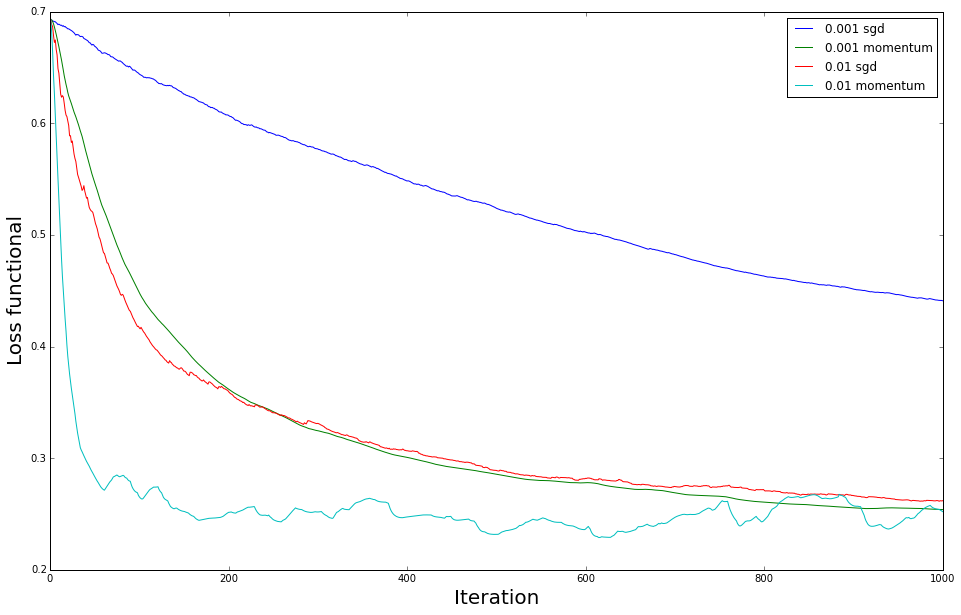

In [446]:
steps = [0.001, 0.01]
plt.figure(figsize=(16, 10))
for step in steps:
    w, losses = sgd(X_train, y_train, step)
    plt.plot(range(1, len(losses) + 1)[:1000], losses[:1000], label = str(step) + ' sgd')
    print 'step = ', step, 'converged: iter = ', len(losses)
    w, losses = sgd_momentum(X_train, y_train, step)
    plt.plot(range(1, len(losses) + 1)[:1000], losses[:1000], label = str(step) + ' momentum')
    print 'step = ', step, 'converged: iter = ', len(losses)
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что использование метода Momentum увеличило скорость сходимости.

step =  0.01 converged: iter =  6314
step =  0.01 converged: iter =  10000
step =  0.01 converged: iter =  10000
step =  0.01 converged: iter =  10000


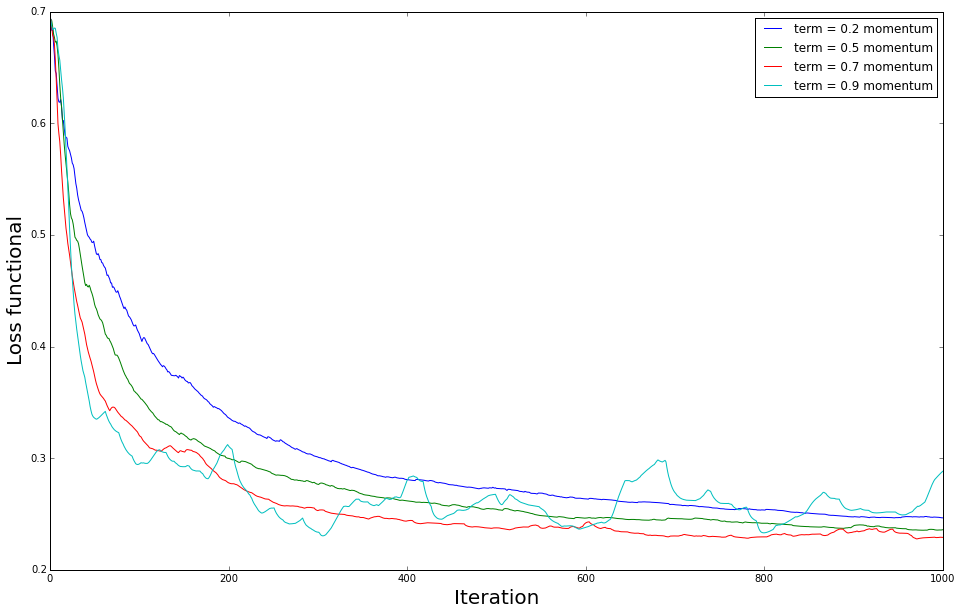

In [450]:
terms = [0.2, 0.5, 0.7, 0.9]
steps = 0.01
plt.figure(figsize=(16, 10))
for term in terms:
    w, losses = sgd_momentum(X_train, y_train, step, momentum_term=term)
    plt.plot(range(1, len(losses) + 1)[:1000], losses[:1000], label = 'term = ' + str(term) + ' momentum')
    print 'step = ', step, 'converged: iter = ', len(losses)
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что чем меньше momentum term, тем медленнее, но качественней сходимость.

In [459]:
def adagrad(x, y, step, n_iters=10000, rand_init=False, C=0.0):
    if rand_init:
        w = (np.random.rand(x.shape[1]).reshape((x.shape[1], 1)) - 0.5) / x.shape[0]
        w_new = w
    else:
        w = np.zeros((x.shape[1], 1))
        w_new = np.zeros((x.shape[1], 1))
    losses = []
    epsilon = 1e-8
    G = np.zeros((x.shape[1], x.shape[1]))
    for i in range(n_iters):
        losses.append(compute_functional(x, y, w, C))
        index = np.random.randint(0, y.size - 1)
        gradient = stochastic_gradient(x, y, w, index)
        G += np.square(gradient)
        #M = 1 / np.sqrt(np.diag(G) + epsilon)
        #w_new = w - step * M.dot(gradient + C * w)
        for j in range(x.shape[1]):
            dif = step * gradient[j] / math.sqrt(G[j, j] + epsilon)
            w_new[j] = w[j] -  dif
        #w_new = w * (1 - step * C) - step * gradient
        #print w_new - w
        #if np.linalg.norm(w_new - w) < 10e-6:
        #    break
        w = w_new
    return w, losses

step =  0.1 converged: iter =  625
step =  0.1 converged: iter =  10000
step =  0.5 converged: iter =  46
step =  0.5 converged: iter =  10000


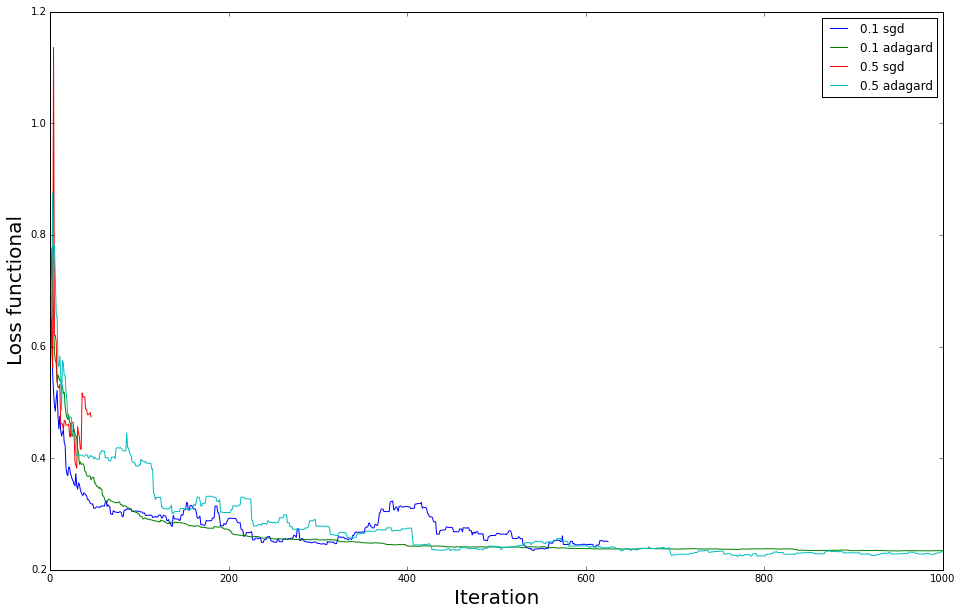

In [461]:
steps = [0.1, 0.5]
plt.figure(figsize=(16, 10))
for step in steps:
    w, losses = sgd(X_train, y_train, step)
    plt.plot(range(1, len(losses) + 1)[:1000], losses[:1000], label = str(step) + ' sgd')
    print 'step = ', step, 'converged: iter = ', len(losses)
    w, losses = adagrad(X_train, y_train, step)
    plt.plot(range(1, len(losses) + 1)[:1000], losses[:1000], label = str(step) + ' adagard')
    print 'step = ', step, 'converged: iter = ', len(losses)
plt.legend()
plt.xlabel('Iteration', size=20)
plt.ylabel('Loss functional', size=20)
plt.show()

Видим, что при шаге $0.1$ sgd сходится не очень (синий график), осциллирует. Использование адаптивного шага улучшило сходимость и она стала плавной (зеленый график). В случае шага $0.5$ sgd показал плохой результат по качеству, adagrad показал неплохой результат.

## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьшиих квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить два подхода.

### Задание

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

In [454]:
from sklearn.datasets import make_regression

In [482]:
X, y = make_regression(n_samples=600, n_features=2)

In [483]:
print y.shape
print X.shape

(600,)
(600, 2)


In [484]:
X_train, X_test, y_train, y_test = train_test_split( \
                                    X, y, test_size=0.8, random_state=1538)

**(0.5 балла)** Выпишите как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

Решение задачи линейной регрессии сводится к решению СЛАУ вида $(X^TX+\lambda I)\vec{w} = X^T\vec{y}$. Значит,
$$\vec{w} = (X^TX+\lambda I)^{-1} X^T\vec{y}$$

In [487]:
def predict_linear(x, w):
    return x.dot(w)

In [485]:
def linear_regression(X, y, reg_coef=0.0):
    I = np.eye(X.shape[1])
    A = X.T.dot(X) + reg_coef*I
    right_vector = X.T.dot(y)
    P, L, U = sla.lu(A)
    res_first = sla.solve_triangular(L, P.T.dot(right_vector), lower = True)
    res_second = sla.solve_triangular(U, res_first)
    return res_second


Решение без регуляризации:

In [499]:
w = linear_regression(X_train, y_train)
print 'MSE = ', mean_squared_error(y_test, predict_linear(X_test, w))
print 'w = ', w

MSE =  4.03592743333e-29
w =  [ 20.17059812  91.78376985]


С регуляризацией:

In [508]:
w2 = linear_regression(X_train, y_train, 0.001)
print 'MSE = ', mean_squared_error(y_test, predict_linear(X_test, w2))
print 'w = ', w2

MSE =  5.78253229123e-07
w =  [ 20.17031009  91.78308451]


Недостактки у данного подхода есть, так как надо искать обратную матрицу, а это не всегда просто. В некоторых случаях решение может получиться неустойчивым и будут проблемы переобучения.

**(0.5 балла)** Примените метод стохастического градиентного спуска из задания ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

In [519]:
w, losses = sgd(X_train, y_train, step=0.1)

In [521]:
print w

[[-2.16040647]
 [ 2.67157017]]


Полученный вектор сильно отличается по сравнению с точным решением

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимость, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем несколько точек:

In [3]:
from sklearn.cross_validation import train_test_split

In [4]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

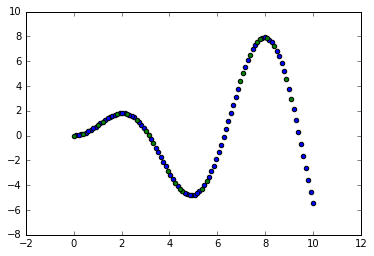

In [5]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

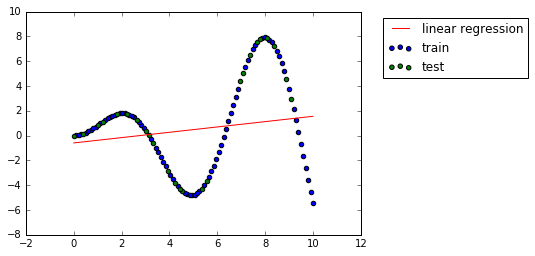

In [12]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$ и в данном случае оно равно:

In [488]:
from sklearn.metrics import mean_squared_error

In [11]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823235

Построенное решение совсем отдаленно напоминает изходную зависимость. Чтобы как-то исправить это одиним из подходов является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$